In [1]:
import numpy as np
import pygsti as pig
import matplotlib.pyplot as plt
import random
import time
import pandas
from scipy.linalg import expm, sqrtm
# from qutip import *

from pygsti.modelmembers.operations import LindbladErrorgen as _LinbladErrorgen
from pygsti.modelmembers.operations import EmbeddedErrorgen as _EmbeddedErrorgen
from pygsti.modelmembers.operations import ExpErrorgenOp as _ExpErrorgenOp
from pygsti.modelmembers.operations import ComposedOp as _ComposedOp
import  pygsti.modelmembers as _mdmb
import pygsti.processors as _proc
import pygsti

from pygsti.tools import pdftools as _pdftools

from pygsti.circuits.gstcircuits import create_lsgst_circuits

from pygsti.models.memberdict import OrderedMemberDict as _OrderedMemberDict
from pygsti.baseobjs.label import Label as _Label, CircuitLabel as _CircuitLabel
from pygsti.circuits import Circuit
import pygsti.circuits as _circ
import pygsti.models as _mdl
from pygsti.modelmembers import operations as _op

In [2]:
def random_circuit(depth, proc_spec):
    """
    works for any 1-qubit model pack and the XYZICnot 2-qubit pack
    """
    layers = []
    for i in range(depth):
        gate = random.choice(proc_spec.gate_names)
        if gate == '(idle)':
            pass
        elif gate == 'Gcnot':
            layers.append((gate, 0, 1))
        else:
            layers.append((gate, random.choice(proc_spec.qubit_labels)))
    return Circuit(layers, proc_spec.qubit_labels)

In [3]:
def vector_from_outcomes(outcomes, num_outcomes):
    vecout = np.zeros((num_outcomes))
    for key in outcomes.keys():
        vecout[int(key[0], 2)] = outcomes[key]
    return(vecout)

def matrix_from_jacob(jacob, num_outcomes):
    matout = np.zeros((num_outcomes, len(jacob['0'*int(np.log2(num_outcomes))])))
    for key in jacob.keys():
        matout[int(key[0], 2), :] = np.array(jacob[key])
    return matout

def tensor_from_hessian(hessian, hilbert_dims):
    """
    returns a 3d-array that when dotted into the state returns the jacobian 
    """
    num_params = len(hessian['0'*int(np.log2(hilbert_dims))])
    tensor_out = np.zeros((hilbert_dims, num_params, num_params))
    for key in hessian.keys():
        tensor_out[int(key[0], 2), :, :] = hessian[key]
    return tensor_out

In [4]:
def compare_models(true_model, model1, model2, circuit_list, name1='x', name2='y'):
    distribution1 = []
    distribution2 = []
    for idx, circ in enumerate(circuit_list): 
        true_outcomes = true_model.probabilities(circ)
        outcome_set1 = model1.probabilities(circ)
        outcome_set2 = model2.probabilities(circ)
        dist1 = _pdftools.tvd(true_outcomes, outcome_set1)
        dist2 = _pdftools.tvd(true_outcomes, outcome_set2)
        distribution1.append(dist1)
        distribution2.append(dist2)
        plt.scatter(dist1, dist2)
    plt.xlabel(name1)
    plt.ylabel(name2)
    mx = max([max(distribution1), max(distribution2)])
    plt.plot((0, mx), (0, mx), c='black')
    plt.show()

In [5]:
def calculate_jacobs(circ_list, model):
    jacobs = {}
    for circ in circ_list:
        hilbert_dims = 2**circ.width
        jacobs[circ] = matrix_from_jacob(model.sim.dprobs(circ), hilbert_dims)
    return jacobs

In [6]:
from pygsti.processors import CliffordCompilationRules as CCR

def make_rb_param(noise_model, model_pack, length_powers=5, circuits_at_length=10):
    pspec = model_pack.processor_spec()
    
    depths = [2**i for i in range(length_powers)]
    
    compilations = {'absolute': CCR.create_standard(pspec, 'absolute', ('paulis', '1Qcliffords'), verbosity=0),            
                'paulieq': CCR.create_standard(pspec, 'paulieq', ('1Qcliffords', 'allcnots'), verbosity=0)}

    design = pig.protocols.DirectRBDesign(model_pack.processor_spec(), compilations, depths, circuits_at_length, qubit_labels=model_pack.processor_spec().qubit_labels, sampler='edgegrab', 
                                           samplerargs=[0.5], randomizeout=True,
                                           citerations=20)
    pig.io.write_empty_protocol_data(design, 'RB_Data', clobber_ok=True)
    pig.io.fill_in_empty_dataset_with_fake_data(noise_model, 'RB_Data/data/dataset.txt', num_samples=1000)
    data = pig.io.load_data_from_dir('RB_Data')
    protocol = pig.protocols.RB()
    results = protocol.run(data)
    return results.fits['full'].estimates['r'] 

In [7]:
def make_dirichlet_covar(counts, hilbert_dims):
    total_counts = sum([counts[key] for key in counts.keys()])    
    count_vec = np.ones(hilbert_dims)
    for key in counts.keys():
        count_vec[int(key[0], 2)] += counts[key]
    prefactor = 1/( (total_counts + hilbert_dims)**2 * (total_counts + hilbert_dims + 1) )
    meas_covar = prefactor*(
        (total_counts + hilbert_dims)*np.diag(count_vec) - np.outer(count_vec, count_vec)
    )
    return meas_covar

In [8]:
def make_multinom_covar(prob_vec):
    return np.eye(len(prob_vec)) - np.outer(prob_vec, prob_vec)

In [12]:
from pygsti.modelpacks import smq1Q_XYI as _smq1Q_XYI
from pygsti.modelpacks import smq1Q_XYZI as _smq1Q_XYZI
from pygsti.modelpacks import smq1Q_XYI as _smq1Q_XZ
from pygsti.modelpacks import smq2Q_XYZICNOT as _smq2Q_XYZICNOT

In [35]:
# make random circuits and design matrices
N_circs = 8000
depth = 15

circ_list = []
for n in range(N_circs):
    circ_list.append(random_circuit(random.choice(range(depth)), MODEL_PACK.processor_spec()))
circ_list = _circ.to_circuits(circ_list) 

jdict = dict()
#hdict = dict()
for idx, circ in enumerate(circ_list):
    if idx%10 == 0:
        print(idx/10, N_circs/10)
    jdict[circ] = matrix_from_jacob(ref_model.sim.dprobs(circ), 2**circ.width)
    #hdict[circ] = tensor_from_hessian(ref_model.sim.hprobs(circ), 2**circ.width)

0.0 800.0
1.0 800.0
2.0 800.0
3.0 800.0
4.0 800.0
5.0 800.0
6.0 800.0
7.0 800.0
8.0 800.0
9.0 800.0
10.0 800.0
11.0 800.0
12.0 800.0
13.0 800.0
14.0 800.0
15.0 800.0
16.0 800.0
17.0 800.0
18.0 800.0
19.0 800.0
20.0 800.0
21.0 800.0
22.0 800.0
23.0 800.0
24.0 800.0
25.0 800.0
26.0 800.0
27.0 800.0
28.0 800.0
29.0 800.0
30.0 800.0
31.0 800.0
32.0 800.0
33.0 800.0
34.0 800.0
35.0 800.0
36.0 800.0
37.0 800.0
38.0 800.0
39.0 800.0
40.0 800.0
41.0 800.0
42.0 800.0
43.0 800.0
44.0 800.0
45.0 800.0
46.0 800.0
47.0 800.0
48.0 800.0
49.0 800.0
50.0 800.0
51.0 800.0
52.0 800.0
53.0 800.0
54.0 800.0
55.0 800.0
56.0 800.0
57.0 800.0
58.0 800.0
59.0 800.0
60.0 800.0
61.0 800.0
62.0 800.0
63.0 800.0
64.0 800.0
65.0 800.0
66.0 800.0
67.0 800.0
68.0 800.0
69.0 800.0
70.0 800.0
71.0 800.0
72.0 800.0
73.0 800.0
74.0 800.0
75.0 800.0
76.0 800.0
77.0 800.0
78.0 800.0
79.0 800.0
80.0 800.0
81.0 800.0
82.0 800.0
83.0 800.0
84.0 800.0
85.0 800.0
86.0 800.0
87.0 800.0
88.0 800.0
89.0 800.0
90.0 800.0
91.0 800.

# Regression

In [19]:
# make a model from a model pack
MODEL_PACK = _smq1Q_XYZI
ref_model = MODEL_PACK.target_model('H+S')
filter_model = MODEL_PACK.target_model('H+S')
regression_model = MODEL_PACK.target_model('H+S')
noise_model = MODEL_PACK.target_model()
noise_model = noise_model.depolarize(max_op_noise=0.0001)
noise_model = noise_model.rotate(max_rotate=0.0001)

In [28]:
# sample circuits
num_samples = 100000000
edesign = pig.protocols.ExperimentDesign(circ_list)
def simulate_taking_data(data_template_filename, noise_model, num_samples):
    """Simulate taking 1-qubit data and filling the results into a template dataset.txt file"""
    datagen_model = noise_model
    pygsti.io.fill_in_empty_dataset_with_fake_data(datagen_model, data_template_filename, num_samples=num_samples, seed=1234)
    
pygsti.io.write_empty_protocol_data(edesign, 'test', clobber_ok=True)

# -- fill in the dataset file in tutorial_files/test_gst_dir/data/dataset.txt --
simulate_taking_data("test/data/dataset.txt", noise_model, num_samples)  # REPLACE with actual data-taking

data = pygsti.io.load_data_from_dir('test')
data_set = data.dataset

In [29]:
# Linear regression
hilbert_dims = 2**len(MODEL_PACK.processor_spec().qubit_labels)
num_params = len(filter_model.to_vector())

pvec = np.zeros((0))
dmat = np.zeros((0, num_params))

for idx, circ in enumerate(circ_list): 
    # calcaulte model probabilities
    p_model = np.zeros(hilbert_dims)
    probs = ref_model.probabilities(circ)
    for key in probs.keys():
        p_model[int(key[0], 2)] = probs[key]
    
    
    # make observation
    freq = vector_from_outcomes(data_set[circ].fractions, hilbert_dims)
    
    pvec = np.hstack((pvec, freq-p_model))
    dmat = np.vstack((dmat, jdict[circ]))

In [1]:
def regression_fit(circ_list, data_set, ref_model, jdict):
    pvec = np.zeros((0))
    jmat = np.zeros((0, num_params))
    
    for circ in circ_list:
        hilbert_dims = 2**circ.width
        
        counts = vector_from_outcomes(data_set[circ].counts, hilbert_dims)
        total_counts = sum(counts)
        observation = (counts + np.ones((hilbert_dims)))/(total_counts + hilbert_dims)
        
        p_model = np.ones((hilbert_dims))
        probs = ref_model.probabilities(circ)
        for key in probs.keys():
            p_model[int(key[0], 2)] += total_counts*probs[key]
        p_model = p_model/(total_counts + hilbert_dims)
        
        pvec = np.hstack((pvec, observation-p_model))
        jmat = np.vstack((jmat, jdict[circ]))
    return np.linalg.pinv(jmat)@pvec
        

In [30]:
xvec = np.linalg.pinv(dmat, 1e-6)@pvec
regression_model.from_vector(xvec)

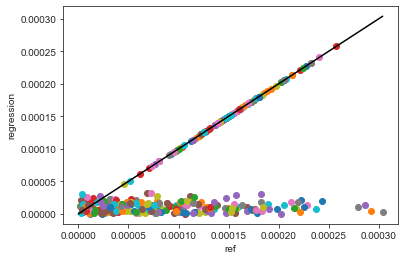

In [31]:
# make random circuits 
N_circs = 350
depth = 10
new_circ_list = []
for n in range(N_circs):
    new_circ_list.append(random_circuit(depth, MODEL_PACK.processor_spec()))

compare_models(noise_model, ref_model, regression_model, new_circ_list, 'ref', 'regression')

---

# LMS filter

In [32]:
# LS filter
hilbert_dims = 2**len(MODEL_PACK.processor_spec().qubit_labels)
num_params = len(filter_model.to_vector())

xvec = np.zeros((num_params))
P = np.eye(num_params)

for idx, circ in enumerate(circ_list): 
    # calcaulte model probabilities
    p_model = np.zeros(hilbert_dims)
    probs = ref_model.probabilities(circ)
    for key in probs.keys():
        p_model[int(key[0], 2)] = probs[key]
    
    # make observation
    freq = vector_from_outcomes(data_set[circ].fractions, hilbert_dims)
    
    H = jdict[circ]
    
    for i in range(len(freq)):
        hrow = H[i, :]
        const = 1/(1 + hrow@P@hrow.T)
        K = const*P@hrow
        innov = freq[i] - p_model[i] - hrow@xvec
        xvec = xvec + K*innov
        P = P - const*P@np.outer(hrow, hrow)@P

In [33]:
filter_model.from_vector(xvec)

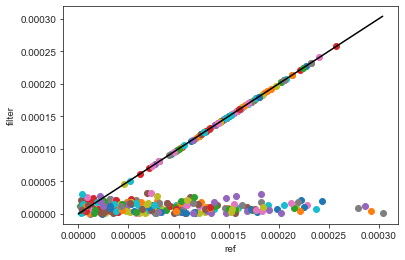

In [34]:
compare_models(noise_model, ref_model, filter_model, new_circ_list, 'ref', 'filter')